In [330]:
import torch
from config import *

In [376]:
from datasets import *
B = 2
shuffle = 1
dataset = ToyDataWithQuestions(split = "train", resolution = (128,128))
#dataset = SpriteWithQuestions(resolution = (128,128))
dataloader = DataLoader(dataset, batch_size = B, shuffle = shuffle)


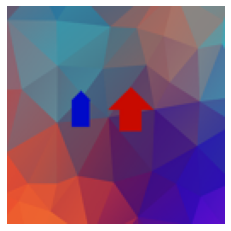

In [377]:
# [Get A Sample Data]
for sample in dataloader:
    sample = sample
plt.axis("off")
plt.imshow(sample["image"][0])

In [384]:

class SlotAttention(nn.Module):
    def __init__(self,num_slots,in_dim=64,slot_dim=64,iters=3,eps=1e-8,hidden_dim=128):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.eps = eps
        self.scale = slot_dim ** -0.5

        self.slots_mu = nn.Parameter(torch.randn(1, num_slots-1, slot_dim))
        self.slots_logsigma = nn.Parameter(torch.zeros(1, num_slots-1, slot_dim))
        nn.init.xavier_uniform_(self.slots_logsigma)
        self.slots_mu_bg = nn.Parameter(torch.randn(1, 1, slot_dim))
        self.slots_logsigma_bg = nn.Parameter(torch.zeros(1, 1, slot_dim))
        nn.init.xavier_uniform_(self.slots_logsigma_bg)
        
        self.kslots_mu = nn.Parameter(torch.randn(1,num_slots,slot_dim))
        self.kslots_logsigma = nn.Parameter(torch.randn(1,num_slots,slot_dim))

        self.to_k = nn.Linear(in_dim, slot_dim, bias=False)
        self.to_v = nn.Linear(in_dim, slot_dim, bias=False)
        self.to_q = nn.Sequential(nn.LayerNorm(slot_dim), nn.Linear(slot_dim, slot_dim, bias=False))
        self.to_q_bg = nn.Sequential(nn.LayerNorm(slot_dim), nn.Linear(slot_dim, slot_dim, bias=False))

        self.gru = nn.GRUCell(slot_dim, slot_dim)
        self.gru_bg = nn.GRUCell(slot_dim, slot_dim)

        hidden_dim = max(slot_dim, hidden_dim)

        self.to_res = nn.Sequential(
            nn.LayerNorm(slot_dim),
            nn.Linear(slot_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, slot_dim)
        )
        self.to_res_bg = nn.Sequential(
            nn.LayerNorm(slot_dim),
            nn.Linear(slot_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, slot_dim)
        )

        self.norm_feat = nn.LayerNorm(in_dim)
        self.slot_dim = slot_dim

    def forward(self,feat,num_slots = None):
        """
        input:
            feat: visual feature with position information, BxNxC
        output: slots: BxKxC, attn: BxKxN
        """
        B, _, _ = feat.shape
        K = num_slots if num_slots is not None else self.num_slots

        mu = self.slots_mu.repeat(B,1,1)#.expand(B, K-1, -1)
        sigma = self.slots_logsigma.exp().repeat(B,1,1)#.expand(B, K-1, -1)
        slot_fg = mu + sigma * torch.randn_like(mu)
        
        mu_bg = self.slots_mu_bg.expand(B, 1, -1)
        sigma_bg = self.slots_logsigma_bg.exp().expand(B, 1, -1)
        slot_bg = mu_bg + sigma_bg * torch.randn_like(mu_bg)
        
        #mu_bg = self.slots_mu.expand(B, 1, -1)
        #sigma_bg = self.slots_logsigma.exp().expand(B, 1, -1)
        #slot_bg = mu_bg + sigma_bg * torch.randn_like(mu_bg)

        feat = self.norm_feat(feat)
        k = self.to_k(feat)
        v = self.to_v(feat)

        attn = None
        for _ in range(self.iters):
            slot_prev_bg = slot_bg
            slot_prev_fg = slot_fg
            q_fg = self.to_q(slot_fg)
            q_bg = self.to_q_bg(slot_bg)

            dots_fg = torch.einsum('bid,bjd->bij', q_fg, k) * self.scale
            dots_bg = torch.einsum('bid,bjd->bij', q_bg, k) * self.scale
            dots = torch.cat([dots_bg, dots_fg], dim=1)  # BxKxN
            attn = dots.softmax(dim=1) + self.eps  # BxKxN
            attn_bg, attn_fg = attn[:, 0:1, :], attn[:, 1:, :]  # Bx1xN, Bx(K-1)xN
            attn_weights_bg = attn_bg / attn_bg.sum(dim=-1, keepdim=True)  # Bx1xN
            attn_weights_fg = attn_fg / attn_fg.sum(dim=-1, keepdim=True)  # Bx(K-1)xN

            updates_bg = torch.einsum('bjd,bij->bid', v, attn_weights_bg)
            updates_fg = torch.einsum('bjd,bij->bid', v, attn_weights_fg)

            slot_bg = self.gru_bg(
                updates_bg.reshape(-1, self.slot_dim),
                slot_prev_bg.reshape(-1, self.slot_dim)
            )
            slot_bg = slot_bg.reshape(B, -1, self.slot_dim)
            slot_bg = slot_bg + self.to_res_bg(slot_bg)

            slot_fg = self.gru(
                updates_fg.reshape(-1, self.slot_dim),
                slot_prev_fg.reshape(-1, self.slot_dim)
            )
            slot_fg = slot_fg.reshape(B, -1, self.slot_dim)
            slot_fg = slot_fg + self.to_res(slot_fg)

        slots = torch.cat([slot_bg, slot_fg], dim=1)
        return slots, attn

slt = SlotAttention(10, 72, 32, 3)
inputs = torch.randn([B,20, 72])
slt, att = slt(inputs)
print(slt.shape, att.shape)

torch.Size([2, 10, 32]) torch.Size([2, 10, 20])


In [333]:
def collect_qa_batch(batch_qa):
    batch_wise_qa = []
    
    for b in range(len(batch_qa[0]["program"])):
        questions_in_batch = {"question":[],"program":[],"answer":[]}
        for qpair in batch_qa:

            try:questions_in_batch["question"].append(qpair["question"][b])
            except: questions_in_batch["question"].append("not generated yet.")
            questions_in_batch["program"].append(qpair["program"][b])
            questions_in_batch["answer"].append(qpair["answer"][b])
        batch_wise_qa.append(questions_in_batch)
    return batch_wise_qa

collect_qa_batch(sample["question"])

[{'question': ['not generated yet.',
   'not generated yet.',
   'not generated yet.',
   'not generated yet.'],
  'program': ['exist(filter(scene(),Circle))',
   'exist(filter(scene(),Cube))',
   'exist(filter(scene(),Diamond))',
   'count(scene())'],
  'answer': ['True', 'True', 'True', '3']},
 {'question': ['not generated yet.',
   'not generated yet.',
   'not generated yet.',
   'not generated yet.'],
  'program': ['exist(filter(scene(),Circle))',
   'exist(filter(scene(),Cube))',
   'exist(filter(scene(),Diamond))',
   'count(scene())'],
  'answer': ['False', 'True', 'True', '2']}]

In [335]:
config.perception = "valkyr"
model = SceneLearner(config)


In [336]:
def evaluate_pose(x, att):
    x = x.permute(0,2,1)
    # x: B3N, att: B1KN1
    # ts: B3k1
    pai = att.sum(dim=3, keepdim=True) # B1K11
    att = att / torch.clamp(pai, min=1e-3)
    ts = torch.sum(
        att * x[:, :, None, :, None], dim=3) # B3K1
    return ts

def equillibrium_loss(att):
    pai = att.sum(dim=3, keepdim=True) # B1K11
    loss_att_amount = torch.var(pai.reshape(pai.shape[0], -1), dim=1).mean()
    return loss_att_amount


def spatial_variance(x, att, norm_type="l2"):
    
    pai = att.sum(dim=3, keepdim=True) # B1K11
    att = att / torch.clamp(pai, min=1e-3)
    ts = torch.sum(
        att * x[:, :, None, :, None], dim=3) # B3K1

    x_centered = x[:, :, None] - ts # B3KN
    x_centered = x_centered.permute(0, 2, 3, 1) # BKN3
    att = att.squeeze(1) # BKN1
    cov = torch.matmul(
        x_centered.transpose(3, 2), att * x_centered) # BK33
    
    # l2 norm
    vol = torch.diagonal(cov, dim1=-2, dim2=-1).sum(2) # BK
    if norm_type == "l2":
        vol = vol.norm(dim=1).mean()
    elif norm_type == "l1":
        vol = vol.sum(dim=1).mean()
    else:
        # vol, _ = torch.diagonal(cov, dim1=-2, dim2=-1).sum(2).max(dim=1)
        raise NotImplementedError
    return vol

In [381]:
import torch
import torch.nn as nn
from types import SimpleNamespace

def evaluate_pose(x, att):
    # x: B3N, att: B1KN1
    # ts: B3k1
    pai = att.sum(dim=3, keepdim=True) # B1K11
    att = att / torch.clamp(pai, min=1e-3)
    ts = torch.sum(
        att * x[:, :, None, :, None], dim=3) # B3K1
    return ts

def equillibrium_loss(att):
    pai = att.sum(dim=3, keepdim=True) # B1K11
    loss_att_amount = torch.var(pai.reshape(pai.shape[0], -1), dim=1).mean()
    return loss_att_amount


def spatial_variance(x, att, norm_type="l2"):
    pai = att.sum(dim=3, keepdim=True) # B1K11
    att = att / torch.clamp(pai, min=1e-3)
    ts = torch.sum(
        att * x[:, :, None, :, None], dim=3) # B3K1

    x_centered = x[:, :, None] - ts # B3KN
    x_centered = x_centered.permute(0, 2, 3, 1) # BKN3
    att = att.squeeze(1) # BKN1
    cov = torch.matmul(
        x_centered.transpose(3, 2), att * x_centered) # BK33
    
    # l2 norm
    vol = torch.diagonal(cov, dim1=-2, dim2=-1).sum(2) # BK
    if norm_type == "l2":
        vol = vol.norm(dim=1).mean()
    elif norm_type == "l1":
        vol = vol.sum(dim=1).mean()
    else:
        # vol, _ = torch.diagonal(cov, dim1=-2, dim2=-1).sum(2).max(dim=1)
        raise NotImplementedError
    return vol

class RDB_Conv(nn.Module):
    def __init__(self, inChannels, growRate, kSize=3):
        super(RDB_Conv, self).__init__()
        Cin = inChannels
        G  = growRate
        self.conv = nn.Sequential(*[
            nn.Conv2d(Cin, G, kSize, padding=(kSize-1)//2, stride=1),
            nn.ReLU(),
        ])

    def forward(self, x):
        out = self.conv(x)
        return torch.cat((x, out), 1)

class RDB(nn.Module):
    def __init__(self, growRate0, growRate, nConvLayers, kSize=3):
        super(RDB, self).__init__()
        G0 = growRate0
        G  = growRate
        C  = nConvLayers

        convs = []
        for c in range(C):
            convs.append(RDB_Conv(G0 + c*G, G))
        self.convs = nn.Sequential(*convs)

        # Local Feature Fusion
        self.LFF = nn.Conv2d(G0 + C*G, G0, 1, padding=0, stride=1)

    def forward(self, x):
        return self.LFF(self.convs(x)) + x

class RDN(nn.Module):
    def __init__(self, args):
        super(RDN, self).__init__()
        self.args = args
        r = args.scale[0]
        G0 = args.G0
        kSize = args.RDNkSize

        # number of RDB blocks, conv layers, out channels
        self.D, C, G = args.RDNconfig
        """
        {
            'A': (20, 6, 32),
            'B': (16, 8, 64),
        }[args.RDNconfig]
        """

        # Shallow feature extraction net
        self.SFENet1 = nn.Conv2d(args.n_colors, G0, kSize, padding=(kSize-1)//2, stride=1)
        self.SFENet2 = nn.Conv2d(G0, G0, kSize, padding=(kSize-1)//2, stride=1)

        # Redidual dense blocks and dense feature fusion
        self.RDBs = nn.ModuleList()
        for i in range(self.D):
            self.RDBs.append(
                RDB(growRate0 = G0, growRate = G, nConvLayers = C)
            )

        # Global Feature Fusion
        self.GFF = nn.Sequential(*[
            nn.Conv2d(self.D * G0, G0, 1, padding=0, stride=1),
            nn.Conv2d(G0, G0, kSize, padding=(kSize-1)//2, stride=1)
        ])

        if args.no_upsampling:
            self.out_dim = G0
        else:
            self.out_dim = args.n_colors
            # Up-sampling net
            if r == 2 or r == 3:
                self.UPNet = nn.Sequential(*[
                    nn.Conv2d(G0, G * r * r, kSize, padding=(kSize-1)//2, stride=1),
                    nn.PixelShuffle(r),
                    nn.Conv2d(G, args.n_colors, kSize, padding=(kSize-1)//2, stride=1)
                ])
            elif r == 4:
                self.UPNet = nn.Sequential(*[
                    nn.Conv2d(G0, G * 4, kSize, padding=(kSize-1)//2, stride=1),
                    nn.PixelShuffle(2),
                    nn.Conv2d(G, G * 4, kSize, padding=(kSize-1)//2, stride=1),
                    nn.PixelShuffle(2),
                    nn.Conv2d(G, args.n_colors, kSize, padding=(kSize-1)//2, stride=1)
                ])
            else:
                raise ValueError("scale must be 2 or 3 or 4.")

    def forward(self, x):
        f__1 = self.SFENet1(x)
        x  = self.SFENet2(f__1)

        RDBs_out = []
        for i in range(self.D):
            x = self.RDBs[i](x)
            RDBs_out.append(x)

        x = self.GFF(torch.cat(RDBs_out,1))
        x += f__1

        if self.args.no_upsampling:
            return x
        else:
            return self.UPNet(x)

class GraphConvolution(nn.Module):

    def __init__(self, input_feature_num, output_feature_num, add_bias=True, dtype=torch.float,
                 batch_normal=True):
        super().__init__()
        # shapes

        self.input_feature_num = input_feature_num
        self.output_feature_num = output_feature_num
        self.add_bias = add_bias
        self.batch_normal = batch_normal

        # params
        latent_dim = 128
        self.weight = FCBlock(128,2,input_feature_num, latent_dim)
        self.bias = nn.Parameter(torch.randn(latent_dim,dtype=dtype))
        self.transform = FCBlock(128,2,latent_dim, self.output_feature_num)
        
        self.sparse = True
        #self.batch_norm = nn.BatchNorm1d(num_features = input_feature_num)
            
    def set_trainable(self, train=True):
        for param in self.parameters():
            param.requires_grad = train

    def forward(self, x, adj):
        """
        @param inp : adjacent: (batch, graph_num, graph_num) cat node_feature: (batch, graph_num, in_feature_num) -> (batch, graph_num, graph_num + in_feature_num)
        @return:
        """
        B, N, D = x.shape
        node_feature = x

        x = self.weight(node_feature)
        #x = torch.nn.functional.normalize(x,p = 1.0, dim = -1, eps = 1e-5)

        if self.sparse or isinstance(adj, torch.SparseTensor):
            x = torch.spmm(adj,x[0]).unsqueeze(0)
        else:
            x = torch.matmul(adj,x[0])
        #if self.add_bias:
        x = x + self.bias.unsqueeze(0).unsqueeze(0).repeat(B,N,1)

        x = self.transform(x)

        #x = torch.nn.functional.normalize(x,p = 1.0, dim = -1, eps = 1e-5)

        return x

class GNNSoftPooling(nn.Module):
    def __init__(self, input_feat_dim, output_node_num = 10):
        super().__init__()
        self.assignment_net = GraphConvolution(input_feat_dim, output_node_num)
        self.feature_net =   GraphConvolution(input_feat_dim, input_feat_dim) 
    
    def forward(self, x, adj):
        B,N,D = x.shape
        if isinstance(adj, list):
            output_node_features = []
            output_new_adj = []
            output_s_matrix = []
            scale = 50
            for i in range(len(adj)):
                s_matrix = self.assignment_net(x[i:i+1], adj[i]) #[B,N,M]
                
                s_matrix = torch.softmax(s_matrix * scale , dim = 2)#.clamp(0.0+eps,1.0-eps)
            
                node_features = self.feature_net(x[i:i+1],adj[i]) #[B,N,D]
                node_features = torch.einsum("bnm,bnd->bmd",s_matrix,node_features) #[B,M,D]
                # [Calculate New Cluster Adjacency]

                adj[i] = adj[i]

                new_adj = torch.spmm(
                    torch.spmm(
                        s_matrix[0].permute(1,0),adj[i]
                        ),s_matrix[0])
                #new_adj = new_adj / new_adj.max()

                output_node_features.append(node_features)
                output_new_adj.append(new_adj)
                output_s_matrix.append(s_matrix)

            output_node_features = torch.cat(output_node_features, dim = 0)
            output_s_matrix = torch.cat(output_s_matrix, dim = 0)
        return output_node_features,output_new_adj,output_s_matrix

def get_fourier_feature(grid, term = 7):
    output_feature = []
    for k in range(term):
        output_feature.append(torch.sin(grid * (k + 1)))
        output_feature.append(torch.cos(grid * (k + 1)))
    output_feature = torch.cat(output_feature, dim = -1)
    return output_feature

class ObjectRender(nn.Module):
    def __init__(self,config, conv_feature_dim):
        super().__init__()
        channel_dim = config.channel
        spatial_dim = config.spatial_dim
        fourier_dim = config.fourier_dim

        self.conv_feature_dim = conv_feature_dim
        self.render_block  = FCBlock(128,3,conv_feature_dim + spatial_dim + spatial_dim + 2*spatial_dim*fourier_dim,channel_dim)

    def forward(self, latent, grid):
        B,N,D = latent.shape
        if len(grid.shape) == 4:
            # grid: [B,W,H,2]
            B, W, H, _ = grid.shape
            expand_latent = latent.unsqueeze(2).unsqueeze(2)
            expand_latent = expand_latent.repeat(1,1,W,H,1)
            grid = grid.unsqueeze(1)
            grid = grid.repeat(1,N,1,1,1)
        if len(grid.shape) == 3:
            # grid: [B,WH,2]
            B, WH, _ = grid.shape
            grid = grid.unsqueeze(1).repeat(1,N,1,1)
            expand_latent = latent.unsqueeze(2).repeat(1,1,WH,1)
        cat_feature = torch.cat([grid, expand_latent], dim = -1)
        return self.render_block(cat_feature)


class ValkyrNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        device = config.device
        # construct the grid domain connection
        self.imsize = config.imsize
        self.perception_size = config.perception_size
        # build the connection graph for the grid domain
        self.spatial_coords = grid(self.imsize,self.imsize,device=device)
        self.spatial_fourier_features = get_fourier_feature(self.spatial_coords, term = config.fourier_dim).to(device)
        self.spatial_edges =  build_perception(self.imsize,self.perception_size,device = device).to_dense().to(device)
        # [Grid Convs]
        conv_feature_dim = config.conv_feature_dim
        self.grid_convs = RDN(SimpleNamespace(G0=conv_feature_dim  ,RDNkSize=3,n_colors=3,RDNconfig=(4,3,16),scale=[2],no_upsampling=True))
        
        # [Diff Pool Construction]
        hierarchy_nodes = config.hierarchy_construct 
        self.diff_pool = nn.ModuleList([
            GNNSoftPooling(input_feat_dim = conv_feature_dim+2,output_node_num = node_num ) for node_num in hierarchy_nodes
        ])
        

        # [Render Fields]
        self.render_fields = nn.ModuleList([ObjectRender(config, conv_feature_dim) for _ in hierarchy_nodes])

        self.conv2object_feature = nn.Linear(conv_feature_dim + 2, config.object_dim)
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
    
    def forward(self, x, verbose = 0):
        outputs = {}
        B,W,H,C = x.shape # input shape
        device = self.device

        # [Grid Convolution] produce initial feature in the grid domain 
        grid_conv_feature = self.grid_convs(x.permute(0,3,1,2)).to(device).permute(0,2,3,1)

        _,_,_,D = grid_conv_feature.shape
        coords_added_conv_feature = torch.cat(
            [grid_conv_feature, self.spatial_coords.unsqueeze(0).repeat(B,1,1,1).to(device)], dim = 3
        )
        if verbose:print("coords_added_conv_feature:{}x{}x{}x{}".format(*list(coords_added_conv_feature.shape) ))

        coords_added_conv_feature = coords_added_conv_feature.reshape(B,W*H,(D+2))
        coords_added_conv_feature = F.normalize(coords_added_conv_feature, dim = 2, p=1.0)
       
        # [DiffPool] each layer performs differentiable [Pn invariant] pooling 

        convs_features = []
        cluster_assignments = []
        curr_x = coords_added_conv_feature # base layer feature
  
        curr_edges = [self.spatial_edges for _ in range(B)] # base layer edges
        convs_features.append(curr_x)
        entropy_regular = 0.0 # initialize the entropy loss
        loc_loss = 0.0        # localization loss
        equi_loss = 0.0       # equillibrium loss
        scene_tree = {
            "x":[curr_x],
            "object_features":[self.conv2object_feature(curr_x)],
            "object_scores":[torch.ones(B,curr_x.shape[1]).to(self.device)],
            "connections":[],
            "edges":[self.spatial_edges]}
        outputs["masks"] = []
        outputs["poses"] = []

        layer_reconstructions = []
        layer_masks = [torch.ones(B,curr_x.shape[1]).to(self.device)]  # maintain a mask
        for i,graph_pool in enumerate(self.diff_pool):
            curr_x, curr_edges, assignment_matrix = graph_pool(curr_x, curr_edges)
            B,N,M = assignment_matrix.shape
            assignment_matrix = scene_tree["object_scores"][-1].unsqueeze(2).repeat(1,1,M) * assignment_matrix
            #assignment_matrix = F.normalize(assignment_matrix, dim = 2)

            # previous level mask calculation
            prev_mask = layer_masks[-1]
            if len(prev_mask.shape) == 2:
                layer_mask = assignment_matrix #[BxNxWxHx1]
            else:layer_mask = torch.bmm(prev_mask,assignment_matrix)


            layer_masks.append(layer_mask)
                        
            exist_prob = torch.max(assignment_matrix,dim = 1).values
            #exist_prob = torch.ones(B, assignment_matrix.shape[-1]).to(device)

            # [Equivariance Loss]
            equis =assignment_matrix.unsqueeze(1).unsqueeze(-1)
            equi_loss += equillibrium_loss(equis)
            
            cluster_assignments.append(assignment_matrix)
            convs_features.append(curr_x)

            # [Scene Reconstruction]
            syn_grid = torch.cat([self.spatial_coords.to(device)\
                                  ,self.spatial_fourier_features.to(device)], dim = -1).unsqueeze(0).repeat(B,1,1,1)

            layer_recons = self.render_fields[i](
                curr_x,
                syn_grid
                )

            if verbose: print("reconstruction with shape: ", layer_recons.shape)
            layer_reconstructions.append(layer_recons)
            
            if verbose:print(assignment_matrix.max(),assignment_matrix.min(), curr_edges[0].shape, curr_edges[0].max(), curr_edges[0].min())
            
            # [Regular Entropy Term]
            
            layer_mask
            outputs["masks"].append(layer_mask)
            
            points = self.spatial_coords.unsqueeze(0).repeat(B,1,1,1).reshape(B,W*H,2)

            variance = spatial_variance(points, layer_mask.permute(0,2,1), norm_type="l2")
            loc_loss += variance.mean()

            # [Poses]
            # [B,N,K] [B,N,2]
            poses = torch.matmul(layer_mask.permute(0,2,1),points)/layer_mask.sum(1).unsqueeze(-1)
   
            outputs["poses"].append({"centers":poses,"vars":variance})

            entropy_regular += assignment_entropy(assignment_matrix)

            # load results to the scene tree
            scene_tree["x"].append(curr_x)
            scene_tree["object_features"].append(self.conv2object_feature(curr_x))
            scene_tree["object_scores"].append(exist_prob)
            scene_tree["connections"].append(assignment_matrix)
            scene_tree["edges"].append(curr_edges)

        # [Calculate Reconstruction at Each Layer]
        outputs["reconstructions"] = []

        reconstruction_loss = 0.0

        for i,recons in enumerate(layer_reconstructions):

            B,N,W,H,C = recons.shape

            exist_prob = scene_tree["object_scores"][i+1]\
                .unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1,1,W,H,C) 

            mask = layer_masks[i+1].permute(0,2,1).reshape(B,N,W,H,1)

            recons = recons * mask * exist_prob
            
            #layer_recon_loss = torch.nn.functional.mse_loss(recons, x.unsqueeze(1).repeat(1,N,1,1,1))
            layer_recon_loss = torch.nn.functional.mse_loss(recons.sum(dim = 1), x)
            reconstruction_loss += layer_recon_loss
            outputs["reconstructions"].append(recons)


        # [Output the Scene Tree]
        outputs["scene_tree"] = scene_tree

        # [Add all the loss terms]
        outputs["losses"] = {"entropy":entropy_regular,"reconstruction":reconstruction_loss,"equi":equi_loss,"localization":loc_loss}
        return outputs

def evaluate_pose(x, att):
    # x: BN3, att: BKN
    # ts: B3k1
    att = att.unsqueeze(1).unsqueeze(-1)
    x = x.permute(0,2,1)
    pai = att.sum(dim=3, keepdim=True) # B1K11
    att = att / torch.clamp(pai, min=1e-3)
    ts = torch.sum(
        att * x[:, :, None, :, None], dim=3) # B3K1
    return ts.permute(0,2,1,3).squeeze(-1)

def spatial_variance(x, att, norm_type="l2"):
    # att: BKN x: BN3
    x = x.permute(0,2,1)
    att = att.unsqueeze(1).unsqueeze(-1)
    pai = att.sum(dim=3, keepdim=True) # B1K11
    att = att / torch.clamp(pai, min=1e-3)
    ts = torch.sum(
        att * x[:, :, None, :, None], dim=3) # B3K1

    x_centered = x[:, :, None] - ts # B3KN
    x_centered = x_centered.permute(0, 2, 3, 1) # BKN3
    att = att.squeeze(1) # BKN1
    cov = torch.matmul(
        x_centered.transpose(3, 2), att * x_centered) # BK33
    
    # l2 norm
    vol = torch.diagonal(cov, dim1=-2, dim2=-1).sum(2) # BK
    if norm_type == "l2":
        vol = vol.norm(dim=1)
    elif norm_type == "l1":
        vol = vol.sum(dim=1)
    else:
        # vol, _ = torch.diagonal(cov, dim1=-2, dim2=-1).sum(2).max(dim=1)
        raise NotImplementedError
    return vol

def assignment_entropy(s_matrix):
    # s_matrix: B,N,M
    EPS = 1e-6
    output_entropy = 0
    for b in range(s_matrix.shape[0]):
        for i in range(s_matrix.shape[1]):
            input_tensor = s_matrix[b][i:i+1,:].clamp(EPS, 1-EPS)

            lsm = nn.LogSoftmax(dim = -1)
            log_probs = lsm(input_tensor)
            probs = torch.exp(log_probs)
            p_log_p = log_probs * probs
            entropy = -p_log_p.mean()
            #print(entropy)
            output_entropy += entropy
    output_entropy *= 0
    return output_entropy
    

def equillibrium_loss(att):
    pai = att.sum(dim=3, keepdim=True) # B1K11
    loss_att_amount = torch.var(pai.reshape(pai.shape[0], -1), dim=1).mean()
    return loss_att_amount

def build_perception(size,length,device):
    edges = [[],[]]
    for i in range(size):
        for j in range(size):
            # go for all the points on the grid
            coord = [i,j];loc = i * size + j

            for dx in range(-length,length+1):
                for dy in range(-length,length+1):
                    if i+dx < size and i+dx>=0 and j+dy<size and j+dy>=0:
                        if (i+dx) * size + (j + dy) != loc:
                            edges[0].append(loc)
                            edges[1].append( (i+dx) * size + (j + dy))
                            edges[0].append( (i+dx) * size + (j + dy))
                            edges[1].append(loc)
    outputs = torch.sparse_coo_tensor(edges, torch.ones(len(edges[0])), size = (size**2, size**2))
    return outputs.to(device)

def grid(width, height, device = "cuda:0" if torch.cuda.is_available() else "cpu"):
    x = torch.linspace(0,1,width)
    y = torch.linspace(0,1,height)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
    return torch.cat([grid_x.unsqueeze(0),grid_y.unsqueeze(0)], dim = 0).permute(1,2,0)
    

In [338]:
config.perception_size = 2
config.hierarchy_construct = [7,5,3]
config.conv_feature_dim = 32
model.scene_perception = ValkyrNet(config)

perception_outputs = model.scene_perception(sample["image"])
scene_tree = perception_outputs["scene_tree"]

In [339]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
optimizer.zero_grad()
working_loss = 0
for key in perception_outputs["losses"]: working_loss += perception_outputs["losses"][key]
working_loss.backward()
optimizer.step()

In [340]:

def build_scene_tree(perception_outputs):
    all_kwargs = []
    scene_tree = perception_outputs["scene_tree"]
    scores = scene_tree["object_scores"]
    features = scene_tree["object_features"]
    connections = scene_tree["connections"]

    B = features[0].shape[0]
    for b in range(B):
        kw_scores, kw_features, kw_connections = [score[b] for score in scores], [feature[b] for feature in features], \
        [connection[b] for connection in connections]
        kwargs = {"features":kw_features, "end":kw_scores, "connections":kw_connections}
        all_kwargs.append(kwargs)
    return all_kwargs


In [341]:
scene_tree = perception_outputs["scene_tree"]

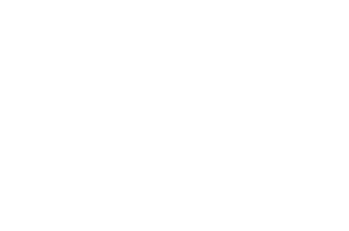

In [342]:
b = 1
vis_scores = [score[b].detach() for score in scene_tree["object_scores"][1:]]
vis_connections = [connect[b] for connect in scene_tree["connections"][1:]]


visualize_tree(vis_scores, vis_connections, scale = 1.618)


In [343]:

for mask in perception_outputs["masks"]:
    print(mask.shape,mask.max(), mask.min())
    print(torch.sum(mask, dim = 2))


torch.Size([2, 16384, 7]) tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], grad_fn=<SumBackward1>)
torch.Size([2, 16384, 5]) tensor(1.0000, grad_fn=<MaxBackward1>) tensor(2.8026e-45, grad_fn=<MinBackward1>)
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], grad_fn=<SumBackward1>)
torch.Size([2, 16384, 3]) tensor(1.0000, grad_fn=<MaxBackward1>) tensor(1.2713e-38, grad_fn=<MinBackward1>)
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], grad_fn=<SumBackward1>)


/var/folders/tp/c2bzzvd17y35z8x_20mfhn700000gn/T/ipykernel_31483/63699579.py:47: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,batch_size,i + 1,frameon=False)


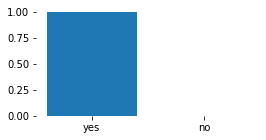

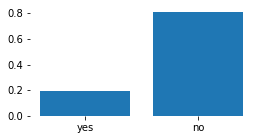

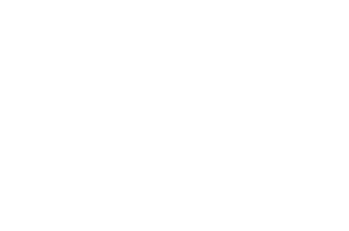

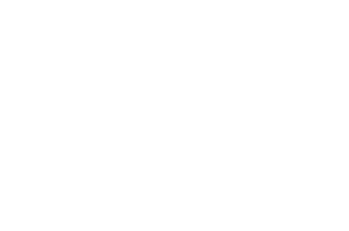

In [344]:
# [Visualize Predicate Segmentation]
batch_kwargs = build_scene_tree(perception_outputs)
#model.executor.effective_level = 3
programs = ["exist(scene())","exist(filter(scene(),house))"]
for b in range(B):
    kwargs = batch_kwargs[b]

    q = programs[b]
    q = model.executor.parse(q)
    o = model.executor(q, **kwargs)
    # [Visualize the Output Mask Scene Tree]
    answer_distribution_binary(o["end"].sigmoid().cpu().detach())
    plt.show()


programs = ["scene()","filter(scene(),house)"]
for b in range(B):
    kwargs = batch_kwargs[b]
    q = programs[b]
    q = model.executor.parse(q)
    o = model.executor(q, **kwargs)

    # [Visualize the Output Mask Scene Tree]
    vis_connections = [connect[b] for connect in scene_tree["connections"][1:]]
    vis_scores = [o["end"][i].sigmoid().cpu().detach() for i in range(4)][1:]
    
    visualize_tree(vis_scores, vis_connections, scale = 1.618)
    plt.show()

#masks = calculate_masks()


[1.0000000e+00 2.2067058e-36 4.9923345e-09]
[5.3831890e-30 8.3237129e-43 1.0000000e+00 3.9782551e-09 1.9299127e-22]
[1.0000000e+00 1.0000000e+00 3.1126823e-11 1.2867882e-26 1.5275756e-09
 1.1483974e-24 1.1537211e-03]


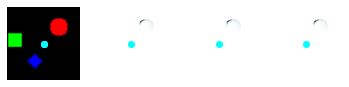

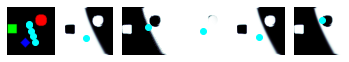

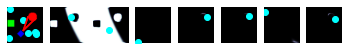

In [345]:
def calculate_masks(scores, connections):
    all_masks = []
    for i in range(len(connections)):
        curr_mask = scores[i+1].unsqueeze(-1)
        for connection in reversed(connections[:i+1]):
            curr_mask = torch.bmm(connection, curr_mask) # [BxNxM],[BxM]
        all_masks.append(curr_mask)
    return all_masks

vis_score = scene_tree["object_scores"]
#vis_score[-1][0][1] = 0.5
print(vis_score[-1][0].cpu().detach().numpy())
print(vis_score[-2][0].cpu().detach().numpy())
print(vis_score[-3][0].cpu().detach().numpy())
all_masks = calculate_masks(vis_score,scene_tree["connections"])


def display_batch(sample,outputs,batch = 0,file_name = "temp.png"):
    
    B, W, H, C = sample["image"].shape
    for i, masks in enumerate(reversed(outputs["masks"])):
        plt.figure("display_{}".format(i))
        B, N, K = masks.shape
        plt.subplot(1, K + 1, 1)
        plt.axis("off")
        plt.imshow(sample["image"][0])

        layer_connection = outputs["scene_tree"]["edges"][-i-1][batch].detach()
        poses = outputs["poses"][-i-1]["centers"][batch].detach()
        poses[:,1] = 1 - poses[:,1]
        poses[:,0] = 1 - poses[:,0]
    
        for i in range(K):
            for j in range(K):
                plt.plot((W*poses[i,0],W*poses[j,0]),\
                         (H*poses[i,1],H*poses[j,1]),color = "red",\
                             alpha = float(layer_connection[i][j].clamp(0.0,1.0))
                    )
        plt.scatter(poses[:,0] * W, H-poses[:,1] * H, c = "cyan")


        for j in range(K):
            plt.subplot(1, K + 1, 2 + j)
            plt.axis("off")
            plt.imshow(masks.detach()[batch][:,j].reshape(W,H), cmap="bone")
            plt.scatter(poses[j,0] * W, poses[j,1] * H, c = "cyan")
        
    return 0

#plt.axis("off")
#mask = scene_tree["connections"][0].reshape(2,128,128,5).detach()
#N = 5
#for i in range(N):
#    plt.subplot(1,N,i + 1)
#    plt.axis("off")
#    plt.imshow(mask[0,:,:,i])
#plt.show()

#plt.axis("off")
#plt.imshow(sample["image"][0])

display_batch(sample,perception_outputs)
plt.show()

In [346]:

x = torch.randn(2, 100, 2)
attn = (torch.randn(2,5,100 ) ** 2).clamp(0.,1.0)

local_loss = spatial_variance(x, attn)
print(local_loss)

tensor([4.3705, 4.0397])


In [378]:
#[来点机械的]
class ObjectRender(nn.Module):
    def __init__(self,config, conv_feature_dim):
        super().__init__()
        channel_dim = config.channel
        spatial_dim = config.spatial_dim
        fourier_dim = config.fourier_dim

        self.conv_feature_dim = conv_feature_dim
        self.render_block  = FCBlock(128,3,conv_feature_dim,channel_dim)

    def forward(self, latent, grid):
        B,N,D = latent.shape
        if len(grid.shape) == 4:
            # grid: [B,W,H,2]
            B, W, H, _ = grid.shape
            expand_latent = latent.unsqueeze(2).unsqueeze(2)
            expand_latent = expand_latent.repeat(1,1,W,H,1)
            grid = grid.unsqueeze(1)
            grid = grid.repeat(1,N,1,1,1)
        if len(grid.shape) == 3:
            # grid: [B,WH,2]
            B, WH, _ = grid.shape
            grid = grid.unsqueeze(1).repeat(1,N,1,1)
            expand_latent = latent.unsqueeze(2).repeat(1,1,WH,1)
        cat_feature = torch.cat([grid, expand_latent], dim = -1)
        return self.render_block(cat_feature)

nf = 10
def fit(model, images, latent):
    optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
    render_grid = grid(128,128)
    fourier_grid = get_fourier_feature(render_grid, term = nf)
    for epoch in tqdm(range(2000)):
        spatials = torch.cat([
            render_grid, fourier_grid
        ], dim = -1).unsqueeze(0).repeat(2,1,1,1)

        render = model(latent, spatials)
        working_loss = \
            torch.nn.functional.mse_loss(render.sum(1),images)
        optim.zero_grad()
        working_loss.backward()
        optim.step()

objmodel = ObjectRender(config, 128 + 4 * nf + 2)
latent = torch.randn(2,1,128)
fit(objmodel, sample["image"], latent)

100%|██████████| 2000/2000 [03:00<00:00, 11.08it/s]


In [347]:
def assignment_entropy(s_matrix):
    # s_matrix: B,N,M
    EPS = 1e-6
    output_entropy = 0
    for b in range(s_matrix.shape[0]):
        for i in range(s_matrix.shape[1]):
            input_tensor = s_matrix[b][i:i+1,:].clamp(EPS, 1-EPS)

            lsm = nn.LogSoftmax(dim = -1)
            log_probs = lsm(input_tensor)
            probs = torch.exp(log_probs)
            p_log_p = log_probs * probs
            entropy = -p_log_p.mean()
            #print(entropy)
            output_entropy += entropy

    return output_entropy
    

def equillibrium_loss(att):
    pai = att.sum(dim=3, keepdim=True) # B1K11
    loss_att_amount = torch.var(pai.reshape(pai.shape[0], -1), dim=1).mean()
    return loss_att_amount

s_matrix = torch.tensor([
    [0.5,0.4],
    [0.2,0.2],
    [0.3,0.4],
]).unsqueeze(0)

entropy_loss = assignment_entropy(s_matrix)
print(entropy_loss)


equis =s_matrix.unsqueeze(1).unsqueeze(-1)
print(equis.shape)
equi_loss = equillibrium_loss(equis)
print(equi_loss)

tensor(1.0385)
torch.Size([1, 1, 3, 2, 1])
tensor(0.0633)


In [348]:
import networkx as nx

raw_edge = [
    [],
    [],
    []
]
raw_size = 3
coarse_size = 5

S = torch.zeros(raw_size,2).float()

raw_g = nx.Graph()
raw_g.add_edges_from(raw_edge)

A = torch.tensor([
    [0, 0, 1],
    [0, 0, 0],
    [1, 0, 0]
]).float()

new_adj = torch.matmul(S.permute(1,0), torch.matmul(A, S))
print(new_adj)

normalize = torch.softmax(S, dim = 1)
print(normalize)


NetworkXError: Edge tuple [] must be a 2-tuple or 3-tuple.

In [ ]:
from utils.render import *


H, W = (64, 64)
K = ((1, 0, 2),
     (0, 1, 2),
     (0, 0, 1))

c2w = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
])

rays_o, rays_d = get_rays(H, W, K, c2w, 0, 0, 0)